# Network Analysis of Vagrant Developers
<a href="#TODO's">TODO</a><br>
<a href="#Imports">Imports</a><br>
<a href="#Functions">Functions</a><br>
<a href="#Analysis">Analysis</a><br>
<a href="#Graph-Based-Analysis-using-Logistic-Regression,-Random-Forest-Classifer,-and-XGBoost-classifier"><b>Analysis</b> - Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier</a><br>
<a href="#Cross-Validation"><b>Analysis</b> - Cross Validation</a><br>
<a href="#Rebalancing-data"><b>Analysis</b> - Data Rebalancing</a>

## TODO's

<ul>
<li>Implement a new dataframe to store the results from each section. (refer to last cell)</li>
</ul>

## Imports

In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import json
import csv
import numpy
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve, plot_precision_recall_curve, auc, recall_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, LeaveOneOut, KFold, StratifiedKFold, RepeatedKFold, TimeSeriesSplit
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
import statsmodels.api as sm
from ast import literal_eval
from statistics import mean
from collections import Counter
import sys
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def plot_prediction(model, x, y):
    '''
    Plots the predictions made using a linear regression model 
    given the set of dependent variable(s) and the independent variable
        model: Linear Regression Model
        x: Dependent Variable(s)
        y: Independent Variable
    returns: Independent Variable Predictions
    '''
    y_pred = model.predict(x)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red')
    plt.show()
    
    return y_pred

# source: https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-python-scikit-like-r-does
def regression_results(y_true, y_pred):
    '''
    Analyzes the results from the linear regression model prediction using different metrics, such r^2
    '''
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def Loo(model, x, y):
    '''
    Uses the LeaveOneOut cross-validation method provided by SkLearn
    '''
    loo = LeaveOneOut() 
    highestscore = (0, "")
    y_true, y_pred = list(), list()
    
    # Split the data
    for train_index, test_index in loo.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        predictions = model.predict_proba(x_test)
        yhat = model.predict(x_test) 
        
        # determine PRC_AUC score
        score = model.score(x_test, y_test) # NOTE: Removed the following due to errors: prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if score > highestscore[0]:
            highestscore = (model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}")

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[1])
    print("\nModel Score: {}\n".format(highestscore[0]))
    #acc = accuracy_score(y_true, y_pred)
    #print('Accuracy: %.3f' % acc)
    
    
def Loo_short(model, x, y):
    '''
    Uses the shortened version of the LeaveOneOut cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = LeaveOneOut()
    # to see list of scoring methods, go to: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Rkf(model, x, y, threshold=None):
    '''
    Uses the RepeatedKFold cross-validation method provided by SkLearn
    '''
    kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42) 
    #kf.get_n_splits(x)
    #print(kf)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("Average Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)

    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]
    
def Rkf_short(model, x, y):    
    '''
    Uses the shortened version of the RepeatedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Skf(model, x, y, threshold = None):
    '''
    Uses the StratifiedKFold cross-validation method provided by SkLearn
    '''
    skf = StratifiedKFold(n_splits=10, random_state=None)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
            
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]
    
def Skf_short(model, x, y):
    '''
    Uses the shortened version of the StratifiedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = StratifiedKFold(n_splits=10, random_state=None)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))    

def Tss(model, x, y, threshold=None):
    '''
    Uses the TimeSeriesSplit cross-validation method provided by SkLearn
    '''
    tscv = TimeSeriesSplit(n_splits=5)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    rcall = None
    yhat = None
    
    for train_index, test_index in tscv.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue

        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])

        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]

def Tss_short(model, x, y):
    '''
    Uses the shortened version of the TimeSeriesSplit cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = TimeSeriesSplit(n_splits=10)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores))) 
    
def Compare_Model_Scores(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    
    print("Predictions for model 1: ")
    print(prediction_probs1)
    print("\nPredictions for model 2: ")
    print(prediction_probs2)
    '''
    
    #recall1, recall2, precision1, precision2, thresholds_list = get_precision_recall(test_x1, test_x2, y_test, model1, model2)
    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:, 1]) 
    #retrieve probability of being 1(in second column of probs_y)
    
    pr_auc1 = auc(recall1, precision1)
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    
    pr_auc2 = auc(recall2, precision2)
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2
    
def Compare_Model_Scores_Best_Threshold(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    '''


    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:,1])
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    
    pr_auc1 = auc(recall1[ix1:], precision1[ix1:])
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore2[np.isnan(fscore2)] = 0  
    ix2 = np.argmax(fscore2)
    
    pr_auc2 = auc(recall2[ix2:], precision2[ix2:])
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2

def plot_thresholds(model1, model2, test_x1, test_y1, test_x2, test_y2, prediction_probs1, prediction_probs2, title):
    '''Predict test_y values and probabilities based on fitted logistic for both models''' 

    # recall1, recall2, precision1, precision2, threshold_list = get_precision_recall(test_x1, test_x2, test_y1, model1, model2)
    
    precision1, recall1, thresholds1 = precision_recall_curve(test_y1, prediction_probs1[:, 1]) 
    precision2, recall2, thresholds2 = precision_recall_curve(test_y2, prediction_probs2[:, 1])
    
    # convert to f1 score
    # from: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    fscore2[np.isnan(fscore2)] = 0 
    
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    ix2 = np.argmax(fscore2)
    #print(f"F score 1: {fscore1} with ix: {ix1}")
    #print(f"F score 2: {fscore2} with ix: {ix2}")
    print('Best Threshold=%f, F1-Score=%.3f for model 1' % (thresholds1[ix1], fscore1[ix1]))
    print('Best Threshold=%f, F1-Score=%.3f for model 2' % (thresholds2[ix2], fscore2[ix2]))
    
    
    fig = plt.figure()
    
    plt.title(f"PRC for {title}")
    # use marker = "." to see each threshhold value
    plt.plot(recall1[:-1], precision1[:-1], "b", label=f"Model 1\n-----------\n • PRC-AUC score: {auc(recall1[ix1:], precision1[ix1:]):.2f}\n • Best Threshold: {round(thresholds1[ix1], 2):.2f}\n • Best F1-Score: {round(fscore1[ix1], 2):.2f}\n")
    plt.plot(recall2[:-1], precision2[:-1], "r--", label=f"Model 2\n-----------\n • PRC-AUC score: {auc(recall2[ix2:], precision2[ix2:]):.2f}\n • Best Threshold: {round(thresholds2[ix2], 2):.2f}\n • Best F1-Score: {round(fscore2[ix2], 2):.2f}")
    plt.scatter([recall1[ix1], recall2[ix2]], [precision1[ix1], precision2[ix2]], marker='o', color='black', label='Best threshold')
    #plt.annotate('Model 1 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds1[ix1], fscore1[ix1]), (0.38, 0.35), fontsize=8)
    #plt.annotate('Model 2 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds2[ix2], fscore2[ix2]), (0.38, 0.3), fontsize=8)
    
    x1 = np.array(recall1[ix1:], dtype=float)
    x2 = np.array(recall2[ix2:], dtype=float)
    y1 = np.array(precision1[ix1:], dtype=float)
    y2 = np.array(precision2[ix2:], dtype=float)
    y1_opp = np.array(precision1[ix2:], dtype=float)
    
    #plt.fill_between(x1, y1, color='b', alpha=0.5)
    # where=y1_opp<=y2
    #plt.fill_between(x2, y2, color='r', alpha=0.3)
    
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylim([0,1])
    plt.xlim([0,1])
    
    plt.grid()
    plt.show()
    
    return thresholds1[ix1], thresholds2[ix2], fig
    
def simple_threshold_plot(classifier, x_test, y_test):
    predictions = classifier.predict(x_test)
    prc_val = average_precision_score(y_test, predictions)
    disp = plot_precision_recall_curve(classifier, x_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prc_val))
    
def get_precision_recall(test_x1, test_x2, test_y, model1, model2):
    '''
    Get the the preicison and recall values for every data point with each type of threshold
    '''
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, 1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
        
    return recall1, recall2, precision1, precision2, threshold_list

def get_precision_recall_best_thresh(test_x1, test_x2, test_y, model1, model2, best_thresh1=None, best_thresh2=None):
    '''
    Get the the preicison and recall values for every data point with the best threshold
    '''
    limit1, limit2 = 1, 1
    if best_thresh1 != None:
        limit1 = best_thresh1
    if best_thresh2 != None:
        limit2 = best_thresh2
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, limit1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        
    threshold_list = np.arange(0.001, limit2, 0.001)
    for threshold in threshold_list:
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
    return recall1, recall2, precision1, precision2, threshold_list

## Analysis

### Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier

In [3]:
# Create a dataframe of all of the unique commits (i.e. links) between developers and the corresponding folders
graph_df = pd.read_csv("../../Neo4j_output/JiT_Reliability_Output/ActiveMQ.csv")

new_columns = {}

# Generate binary classification for our dataframe based on if a developer 
# introduced a bug or not with the corresponding commit
for index in graph_df.index:
    if graph_df.loc[index, "Bug"] != "INTRODUCED_NEW_BUG":
        graph_df.loc[index, "Bug"] = 0
    else:
        graph_df.loc[index, "Bug"] = 1
        
    # separate each node2vec embedding into it's own unique label
    embeddings = literal_eval(graph_df.loc[index, 'n2vEmbedding'])
    for i, embedding in enumerate(embeddings):
        if f"emb_{i}" not in new_columns:
            new_columns[f"emb_{i}"] = []
            new_columns[f"emb_{i}"].append(embedding)
        else:
            new_columns[f"emb_{i}"].append(embedding)

# delete the n2vEmbedding label, as the list has now been separated into their own unique labels 
del graph_df['n2vEmbedding']
temp_df = pd.DataFrame.from_dict(new_columns)
graph_df = graph_df.join(temp_df)
          
graph_df['Bug'] = graph_df.Bug.astype('int')
x = graph_df["Name"]
y = graph_df["Bug"]

In [4]:
graph_df

,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,emb_0,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,Bruce Snyder,assembly/src/release/example/build.xml,1,1.072101,11.121503,0.604938,0.662222,262.0,17,0.261757,...,-0.827216,-0.383985,0.219686,-0.073077,0.210563,0.373899,-0.311778,-0.215480,0.033889,0.091804
1,Bruce Snyder,activemq-core/src/main/java/org/apache/activem...,1,1.072101,11.121503,0.604938,0.662222,262.0,17,0.261757,...,-0.827216,-0.383985,0.219686,-0.073077,0.210563,0.373899,-0.311778,-0.215480,0.033889,0.091804
2,Bruce Snyder,activemq-core/src/main/java/org/apache/activem...,1,1.072101,11.121503,0.604938,0.662222,262.0,17,0.261757,...,-0.827216,-0.383985,0.219686,-0.073077,0.210563,0.373899,-0.311778,-0.215480,0.033889,0.091804
3,Bruce Snyder,activemq-core/src/main/java/org/apache/activem...,1,1.072101,11.121503,0.604938,0.662222,262.0,17,0.261757,...,-0.827216,-0.383985,0.219686,-0.073077,0.210563,0.373899,-0.311778,-0.215480,0.033889,0.091804
4,Bruce Snyder,activemq-core/src/main/java/org/apache/activem...,1,1.072101,11.121503,0.604938,0.662222,262.0,17,0.261757,...,-0.827216,-0.383985,0.219686,-0.073077,0.210563,0.373899,-0.311778,-0.215480,0.033889,0.091804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72652,Willem Ning Jiang,activemq-camel/pom.xml,0,0.902404,0.000000,0.595142,0.648889,261.0,17,0.379855,...,0.134075,-0.045458,0.269675,-0.348940,0.183147,0.047963,-0.097789,-0.349865,0.396739,0.326052
72653,Willem Ning Jiang,pom.xml,0,0.902404,0.000000,0.595142,0.648889,261.0,17,0.379855,...,0.134075,-0.045458,0.269675,-0.348940,0.183147,0.047963,-0.097789,-0.349865,0.396739,0.326052
72654,Willem Ning Jiang,activemq-web-demo/src/main/webapp/websocket/in...,0,0.902404,0.000000,0.595142,0.648889,261.0,17,0.379855,...,0.134075,-0.045458,0.269675,-0.348940,0.183147,0.047963,-0.097789,-0.349865,0.396739,0.326052
72655,Willem Ning Jiang,activemq-web-demo/src/main/webapp/index.html,0,0.902404,0.000000,0.595142,0.648889,261.0,17,0.379855,...,0.134075,-0.045458,0.269675,-0.348940,0.183147,0.047963,-0.097789,-0.349865,0.396739,0.326052


Print out the class counts for our binary classification. In this case, our results are 40,143 <b>False (0)</b> counts, and 1,947 <b>True (1)</b> counts.

In [5]:
print(graph_df['Bug'].value_counts())
# 2D Array containing all results
results_data = [[None for j in range(9)] for i in range(72)]

0    41183
1    31474
Name: Bug, dtype: int64


Creating models...

In [6]:
cv = StratifiedKFold(n_splits=10, random_state=None)

lr_model1 = LogisticRegression(solver='liblinear', random_state=0)
lr_model2 = LogisticRegression(solver='liblinear', random_state=0)
lr_solvers = ['newton-cg', 'lbfgs', 'liblinear']
lr_penalty = ['l2']
lr_c_values = [100, 10, 1.0, 0.1, 0.01]
lr_grid = dict(solver=lr_solvers,penalty=lr_penalty,C=lr_c_values)
lr1_grid_search = GridSearchCV(estimator=lr_model1, param_grid=lr_grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
lr2_grid_search = GridSearchCV(estimator=lr_model2, param_grid=lr_grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)


rf_model1 = RandomForestClassifier()
rf_model2 = RandomForestClassifier()
n_estimators = [10, 100, 1000]
rf_max_features = ['sqrt', 'log2']
rf_grid = dict(n_estimators=n_estimators, max_features=rf_max_features)
rf1_grid_search = GridSearchCV(estimator=rf_model1, param_grid=rf_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
rf2_grid_search = GridSearchCV(estimator=rf_model2, param_grid=rf_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

xgb_model1 = XGBClassifier(verbosity = 0)
xgb_model2 = XGBClassifier(verbosity = 0)
params = {
        'n_estimators': [10, 100, 1000],
        'learning_rate': [0.001, 0.01, 0.1]
        }
xgb1_grid_search = GridSearchCV(estimator=xgb_model1, param_grid=params, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
xgb2_grid_search = GridSearchCV(estimator=xgb_model2, param_grid=params, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

In [7]:
'''
train_test_split params
-----------------------
graph_df: Graph dataset
test_size: float value between 0.0 and 1.0 representing the precentage of data to be put into the test dataset
random_state = used to create reproducible, or deterministic results.
'''
train, test = train_test_split(graph_df, test_size=0.3, random_state = 5)
train = train.reset_index()
test = test.reset_index()

# Labels used for model 1
labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']

# Labels used for model 2
labels2 = set(list(graph_df.columns))
labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

x1_train = train[labels1]
x2_train = train[labels2]
y_train = train["Bug"]
x1_test = test[labels1]
x2_test = test[labels2]
y_test = test["Bug"]

In [8]:
y_train = y_train.astype(float).astype('int')
y_test = y_test.astype(float).astype('int')

In [9]:
print(train['Bug'].value_counts())
train

0    28817
1    22042
Name: Bug, dtype: int64


,index,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,54054,Hiram R. Chirino,activemq-core/src/main/java/org/apache/activem...,1,10.072097,1115.859111,0.757732,0.825556,62521.0,17,...,-0.181703,-0.128270,0.129651,-0.440655,0.415201,0.168586,-0.433039,0.307767,0.346351,0.190914
1,19447,Dejan Bosanac,activemq-osgi/pom.xml,0,3.979819,546.114541,0.735000,0.803333,7692.0,105,...,-0.147561,0.668894,-0.084854,0.030827,-0.231782,0.269489,-0.197336,-0.106412,0.230463,0.514726
2,18937,Gary Tully,assembly/src/sample-conf/activemq-dynamic-netw...,1,6.296929,674.087278,0.750000,0.816667,23215.0,105,...,0.294391,0.045892,-0.077626,-0.320512,0.358006,-0.101423,-0.485582,0.010730,0.438344,-0.054951
3,38803,Hiram R. Chirino,activeio/activeio-core/src/java/org/{ => apach...,1,10.072097,1115.859111,0.757732,0.825556,62521.0,17,...,-0.181703,-0.128270,0.129651,-0.440655,0.415201,0.168586,-0.433039,0.307767,0.346351,0.190914
4,42502,Hiram R. Chirino,activemq-core/src/main/java/org/apache/activem...,1,10.072097,1115.859111,0.757732,0.825556,62521.0,17,...,-0.181703,-0.128270,0.129651,-0.440655,0.415201,0.168586,-0.433039,0.307767,0.346351,0.190914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50854,59465,Robert Davies,activemq-core/src/test/java/org/apache/activem...,1,4.473765,375.206315,0.696682,0.766667,17518.0,17,...,-0.139578,0.004555,0.289425,-0.241643,0.040315,0.161039,0.128141,0.187659,0.532635,0.330456
50855,5520,Christopher L. Shannon (cshannon),activemq-broker/src/main/java/org/apache/activ...,0,5.208830,2063.599550,0.835227,0.883333,13614.0,144,...,-0.119007,-0.258521,0.078788,0.249161,-0.442228,0.312027,-0.039811,0.339314,0.048485,-0.070706
50856,20463,Guillaume Nodet,pom.xml,1,2.002742,28.640600,0.617647,0.678889,1841.0,17,...,0.091503,0.469639,-0.317059,0.275528,0.028650,0.419781,0.204593,-0.404430,-0.071409,0.330066
50857,18638,Gary Tully,activemq-core/src/main/java/org/apache/activem...,1,6.296929,674.087278,0.750000,0.816667,23215.0,105,...,0.294391,0.045892,-0.077626,-0.320512,0.358006,-0.101423,-0.485582,0.010730,0.438344,-0.054951


Print out the class counts for our binary classification in the training dataset. In this case, our results are 12,060 <b>False (0)</b> counts, and 567 <b>True (1)</b> counts.

In [10]:
print(test['Bug'].value_counts())
test

0    12366
1     9432
Name: Bug, dtype: int64


,index,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,63699,James Strachan,assembly/src/test/java/org/apache/activemq/use...,0,6.172684,460.455674,0.690141,0.762222,18307.0,17,...,0.222936,0.227370,-0.030124,-0.077108,0.488156,0.106473,0.136146,0.034130,0.122557,0.140523
1,43049,Hiram R. Chirino,activemq-leveldb-store/src/main/java/org/apach...,1,10.072097,1115.859111,0.757732,0.825556,62521.0,17,...,-0.181703,-0.128270,0.129651,-0.440655,0.415201,0.168586,-0.433039,0.307767,0.346351,0.190914
2,66148,James Strachan,activemq-core/src/main/java/org/apache/activem...,1,6.172684,460.455674,0.690141,0.762222,18307.0,17,...,0.222936,0.227370,-0.030124,-0.077108,0.488156,0.106473,0.136146,0.034130,0.122557,0.140523
3,27717,Timothy A. Bish,activemq-core/src/main/java/org/apache/activem...,1,5.830766,463.194794,0.746193,0.813333,10654.0,144,...,-0.165432,0.537572,-0.015961,-0.524704,0.144393,0.554170,-0.194867,0.074919,0.141336,0.092474
4,66901,James Strachan,activemq-ra/src/test/java/org/activemq/ra/Conn...,1,6.172684,460.455674,0.690141,0.762222,18307.0,17,...,0.222936,0.227370,-0.030124,-0.077108,0.488156,0.106473,0.136146,0.034130,0.122557,0.140523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21793,5253,Christopher L. Shannon (cshannon),activemq-leveldb-store/.tmpBin/sbt119507145014...,0,5.208830,2063.599550,0.835227,0.883333,13614.0,144,...,-0.119007,-0.258521,0.078788,0.249161,-0.442228,0.312027,-0.039811,0.339314,0.048485,-0.070706
21794,44309,Hiram R. Chirino,activemq-core/src/main/java/org/apache/activem...,1,10.072097,1115.859111,0.757732,0.825556,62521.0,17,...,-0.181703,-0.128270,0.129651,-0.440655,0.415201,0.168586,-0.433039,0.307767,0.346351,0.190914
21795,9386,gtully,activemq-unit-tests/src/test/java/org/apache/a...,0,5.190518,2011.261958,0.794595,0.853333,19978.0,130,...,-0.034253,0.208811,-0.126828,-0.395568,0.433222,-0.182560,0.174112,0.008974,0.061063,0.485857
21796,2521,Nathan Christopher Mittler,openwire-cpp/src/marshal/ActiveMQMessageMarsha...,0,0.659012,0.000000,0.478827,0.495556,1492.0,17,...,-0.213977,-0.059154,-0.636898,-0.140313,0.414363,-0.380500,-0.441641,-0.519824,0.406704,0.516048


In [11]:
'''
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)
'''

lr1_grid_search.fit(x1_train, y_train)
print("Logistic regression grid search 1 complete.")
lr2_grid_search.fit(x2_train, y_train)
print("Logistic regression grid search 2 complete.")
rf1_grid_search.fit(x1_train, y_train)
print("Random Forrest grid search 1 complete.")
rf2_grid_search.fit(x2_train, y_train)
print("Random Forrest grid search 2 complete.")
xgb1_grid_search.fit(x1_train, y_train)
print("XGB grid search 1 complete.")
xgb2_grid_search.fit(x2_train, y_train)
print("XGB grid search 2 complete.")

lr_predictions1 = lr1_grid_search.predict(x1_test)
lr_predictions2 = lr2_grid_search.predict(x2_test)
lr_prediction_probs1 = lr1_grid_search.predict_proba(x1_test)
lr_prediction_probs2 = lr2_grid_search.predict_proba(x2_test)

rf_predictions1 = rf1_grid_search.predict(x1_test)
rf_predictions2 = rf2_grid_search.predict(x2_test)
rf_prediction_probs1 = rf1_grid_search.predict_proba(x1_test)
rf_prediction_probs2 = rf2_grid_search.predict_proba(x2_test)

xgb_predictions1 = xgb1_grid_search.predict(x1_test)
xgb_predictions2 = xgb2_grid_search.predict(x2_test)
xgb_prediction_probs1 = xgb1_grid_search.predict_proba(x1_test)
xgb_prediction_probs2 = xgb2_grid_search.predict_proba(x2_test)

Logistic regression grid search 1 complete.
Logistic regression grid search 2 complete.
Random Forrest grid search 1 complete.
Random Forrest grid search 2 complete.
XGB grid search 1 complete.
XGB grid search 2 complete.


In [12]:
# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr1_grid_search.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr2_grid_search.score(x2_test, y_test)}")
print(f"Logistic regression training best score for model 1: {lr1_grid_search.best_score_}")
print(f"Logistic regression training best score for model 2: {lr2_grid_search.best_score_}")
results_data[0][0] = "Original_Logistic_Regression"
results_data[0][1] = lr1_grid_search.score(x1_test, y_test)
results_data[0][2] = lr2_grid_search.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf1_grid_search.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf2_grid_search.score(x2_test, y_test)}")
print(f"Random Forrest Classification training best score for model 1: {rf1_grid_search.best_score_}")
print(f"Random Forrest Classification training best score for model 2: {rf2_grid_search.best_score_}")
results_data[1][0] = "Original_Random_Forrest"
results_data[1][1] = rf1_grid_search.score(x1_test, y_test)
results_data[1][2] = rf2_grid_search.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb1_grid_search.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb2_grid_search.score(x2_test, y_test)}")
print(f"XGB Classifier training best score for model 1: {xgb1_grid_search.best_score_}")
print(f"XGB Classifier training best score for model 2: {xgb2_grid_search.best_score_}")
results_data[2][0] = "Original_XGB_Classifier"
results_data[2][1] = xgb1_grid_search.score(x1_test, y_test)
results_data[2][2] = xgb2_grid_search.score(x2_test, y_test)

Logistic regression training score for model 1: 0.6903844389393522
Logistic regression training score for model 2: 0.7113955408753097
Logistic regression training best score for model 1: 0.6962975155738216
Logistic regression training best score for model 2: 0.7148980195504577
Random Forrest Classification training score for model 1: 0.7115790439489862
Random Forrest Classification training score for model 2: 0.7112120378016332
Random Forrest Classification training best score for model 1: 0.7150159943175995
Random Forrest Classification training best score for model 2: 0.7151929584016277
XGB Classifier training score for model 1: 0.711533168180567
XGB Classifier training score for model 2: 0.7115790439489862
XGB Classifier training best score for model 1: 0.715055321817734
XGB Classifier training best score for model 2: 0.7150159943175995


Compare model scores for Logistic Regression

In [13]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr1_grid_search, lr2_grid_search)
results_data[0][3] = acc1
results_data[0][4] = acc2
results_data[0][5] = prc_val1
results_data[0][6] = prc_val2
results_data[0][7] = pr_auc1
results_data[0][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf1_grid_search, rf2_grid_search)
results_data[1][3] = acc1
results_data[1][4] = acc2
results_data[1][5] = prc_val1
results_data[1][6] = prc_val2
results_data[1][7] = pr_auc1
results_data[1][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb1_grid_search, xgb2_grid_search)
results_data[2][3] = acc1
results_data[2][4] = acc2
results_data[2][5] = prc_val1
results_data[2][6] = prc_val2
results_data[2][7] = pr_auc1
results_data[2][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.7342031599955938
Average Precision-Recall Score: 0.6184853082119157
PRC-AUC for model 1: 0.7258597423165105
Accuracy: 0.690
Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.76      0.74     12366
           1       0.65      0.60      0.63      9432

    accuracy                           0.69     21798
   macro avg       0.68      0.68      0.68     21798
weighted avg       0.69      0.69      0.69     21798


Scores for model 2
------------------
Roc_Auc Score: 0.7684588328870222
Average Precision-Recall Score: 0.6486887536863128
PRC-AUC for model 2: 0.7248257437113246
Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.70      0.73     12366
           1       0.65      0.72      0.68      9432

    accuracy      

###### Compare Precision-Recall thresholds between models

TODO: Get it to work with randomforrest and XGBoost

Best Threshold=0.296072, F1-Score=0.693 for model 1
Best Threshold=0.418295, F1-Score=0.701 for model 2


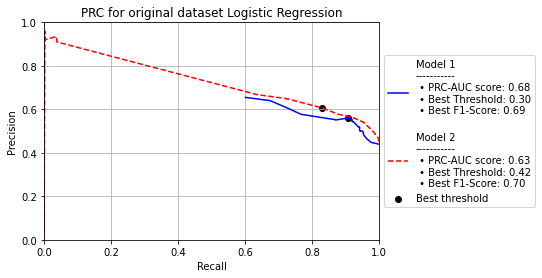

In [14]:
lr_best_threshold1, lr_best_threshold2, lr_og_fig = plot_thresholds(lr1_grid_search, lr2_grid_search, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "original dataset Logistic Regression")

Best Threshold=0.417776, F1-Score=0.701 for model 1
Best Threshold=0.403557, F1-Score=0.701 for model 2


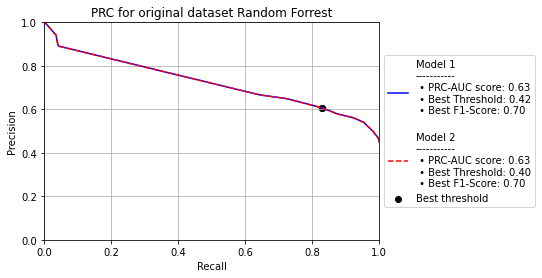

In [15]:
rf_best_threshold1, rf_best_threshold2, rf_og_fig = plot_thresholds(rf1_grid_search, rf2_grid_search, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "original dataset Random Forrest")

Best Threshold=0.410680, F1-Score=0.701 for model 1
Best Threshold=0.418522, F1-Score=0.701 for model 2


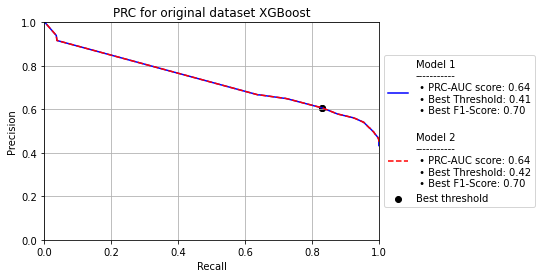

In [16]:
xgb_best_threshold1, xgb_best_threshold2, xgb_og_fig = plot_thresholds(xgb1_grid_search, xgb2_grid_search, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "original dataset XGBoost")

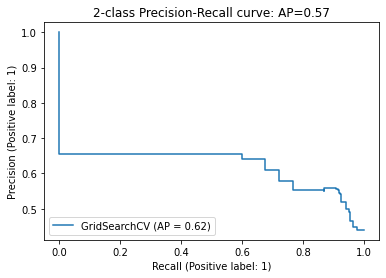

In [17]:
simple_threshold_plot(lr1_grid_search, x1_test, y_test)

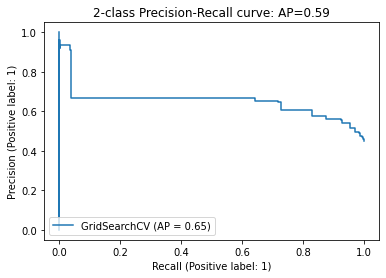

In [18]:
simple_threshold_plot(lr2_grid_search, x2_test, y_test)

Using the best thresholds...

In [19]:
lr_prediction_bestthresh1 = (lr1_grid_search.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr2_grid_search.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr1_grid_search, lr2_grid_search)
results_data[3][0] = "Original_Logistic_Regression_Best_Threshold"
results_data[3][1] = lr1_grid_search.score(x1_test, y_test)
results_data[3][2] = lr2_grid_search.score(x2_test, y_test)
results_data[3][3] = acc1
results_data[3][4] = acc2
results_data[3][5] = prc_val1
results_data[3][6] = prc_val2
results_data[3][7] = pr_auc1
results_data[3][8] = pr_auc2

rf_prediction_bestthresh1 = (rf1_grid_search.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf2_grid_search.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf1_grid_search, rf2_grid_search)
results_data[4][0] = "Original_Random_Forrest_Best_Threshold"
results_data[4][1] = rf1_grid_search.score(x1_test, y_test)
results_data[4][2] = rf2_grid_search.score(x2_test, y_test)
results_data[4][3] = acc1
results_data[4][4] = acc2
results_data[4][5] = prc_val1
results_data[4][6] = prc_val2
results_data[4][7] = pr_auc1
results_data[4][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb1_grid_search.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb2_grid_search.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb1_grid_search, xgb2_grid_search)
results_data[5][0] = "Original_XGBoost_Classifier_Best_Threshold"
results_data[5][1] = xgb1_grid_search.score(x1_test, y_test)
results_data[5][2] = xgb2_grid_search.score(x2_test, y_test)
results_data[5][3] = acc1
results_data[5][4] = acc2
results_data[5][5] = prc_val1
results_data[5][6] = prc_val2
results_data[5][7] = pr_auc1
results_data[5][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.7342031599955938
Average Precision-Recall Score: 0.6184853082119157
PRC-AUC for model 1: 0.6811397420509375
Accuracy: 0.652
Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.46      0.60     12366
           1       0.56      0.91      0.69      9432

    accuracy                           0.65     21798
   macro avg       0.71      0.68      0.65     21798
weighted avg       0.73      0.65      0.64     21798


Scores for model 2
------------------
Roc_Auc Score: 0.7684588328870222
Average Precision-Recall Score: 0.6486887536863128
PRC-AUC for model 2: 0.6309680405944492
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.59      0.69     12366
           1       0.61      0.83      0.70      9432

    accuracy                           0.69     21798
   macro avg       0.71      0.71      0.69     21798
weighted 

### Rebalancing data

#### Undersampling

In [20]:
bug_df = graph_df.loc[graph_df['Bug'] == 1].sample(n=1900, random_state=42)
non_bug_df = graph_df.loc[graph_df['Bug'] == 0].sample(n=1900, random_state=42)
normalized_under_df = pd.concat([bug_df, non_bug_df])
normalized_under_df = normalized_under_df.reset_index()
print(normalized_under_df['Bug'].value_counts())

usx1 = normalized_under_df[labels1]
usx2 = normalized_under_df[labels2]
usy = normalized_under_df["Bug"]
usy = usy.sample(frac=1).reset_index(drop=True) # shuffle dataset

#train, test = train_test_split(normalized_under_df, test_size=0.3, random_state = 5)

labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']
labels2 = set(list(normalized_under_df.columns))
labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

0    1900
1    1900
Name: Bug, dtype: int64


In [21]:
'''
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)
'''

lr1_grid_search.fit(x1_train, y_train)
print("Logistic regression grid search 1 complete.")
lr2_grid_search.fit(x2_train, y_train)
print("Logistic regression grid search 2 complete.")
rf1_grid_search.fit(x1_train, y_train)
print("Random Forrest grid search 1 complete.")
rf2_grid_search.fit(x2_train, y_train)
print("Random Forrest grid search 2 complete.")
xgb1_grid_search.fit(x1_train, y_train)
print("XGB grid search 1 complete.")
xgb2_grid_search.fit(x2_train, y_train)
print("XGB grid search 2 complete.")

lr_predictions1 = lr1_grid_search.predict(x1_test)
lr_predictions2 = lr2_grid_search.predict(x2_test)
lr_prediction_probs1 = lr1_grid_search.predict_proba(x1_test)
lr_prediction_probs2 = lr2_grid_search.predict_proba(x2_test)

rf_predictions1 = rf1_grid_search.predict(x1_test)
rf_predictions2 = rf2_grid_search.predict(x2_test)
rf_prediction_probs1 = rf1_grid_search.predict_proba(x1_test)
rf_prediction_probs2 = rf2_grid_search.predict_proba(x2_test)

xgb_predictions1 = xgb1_grid_search.predict(x1_test)
xgb_predictions2 = xgb2_grid_search.predict(x2_test)
xgb_prediction_probs1 = xgb1_grid_search.predict_proba(x1_test)
xgb_prediction_probs2 = xgb2_grid_search.predict_proba(x2_test)

Logistic regression grid search 1 complete.
Logistic regression grid search 2 complete.
Random Forrest grid search 1 complete.
Random Forrest grid search 2 complete.
XGB grid search 1 complete.
XGB grid search 2 complete.


In [22]:
# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr1_grid_search.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr2_grid_search.score(x2_test, y_test)}")
print(f"Logistic regression training best score for model 1: {lr1_grid_search.best_score_}")
print(f"Logistic regression training best score for model 2: {lr2_grid_search.best_score_}")
results_data[18][0] = "Undersampled_Logistic_Regression"
results_data[18][1] = lr1_grid_search.score(x1_test, y_test)
results_data[18][2] = lr2_grid_search.score(x2_test, y_test)

print(f"Random Forrest training score for model 1: {rf1_grid_search.score(x1_test, y_test)}")
print(f"Random Forrest training score for model 2: {rf2_grid_search.score(x2_test, y_test)}")
print(f"Random Forrest training best score for model 1: {rf1_grid_search.best_score_}")
print(f"Random Forrest training best score for model 2: {rf2_grid_search.best_score_}")
results_data[19][0] = "Undersampled_Random_Forrest"
results_data[19][1] = rf1_grid_search.score(x1_test, y_test)
results_data[19][2] = rf2_grid_search.score(x2_test, y_test)

print(f"XGB training score for model 1: {xgb1_grid_search.score(x1_test, y_test)}")
print(f"XGB training score for model 2: {xgb2_grid_search.score(x2_test, y_test)}")
print(f"XGB training best score for model 1: {xgb1_grid_search.best_score_}")
print(f"XGB training best score for model 2: {xgb2_grid_search.best_score_}")
results_data[20][0] = "Undersampled_XGB_Classifier"
results_data[20][1] = xgb1_grid_search.score(x1_test, y_test)
results_data[20][2] = xgb2_grid_search.score(x2_test, y_test)

Logistic regression training score for model 1: 0.6903844389393522
Logistic regression training score for model 2: 0.7113955408753097
Logistic regression training best score for model 1: 0.6962975155738216
Logistic regression training best score for model 2: 0.7148980195504577
Random Forrest training score for model 1: 0.7115790439489862
Random Forrest training score for model 2: 0.7115790439489862
Random Forrest training best score for model 1: 0.7150553256843647
Random Forrest training best score for model 2: 0.7150159943175995
XGB training score for model 1: 0.711533168180567
XGB training score for model 2: 0.7115790439489862
XGB training best score for model 1: 0.715055321817734
XGB training best score for model 2: 0.7150159943175995


In [23]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr1_grid_search, lr2_grid_search)
results_data[18][3] = acc1
results_data[18][4] = acc2
results_data[18][5] = prc_val1
results_data[18][6] = prc_val2
results_data[18][7] = pr_auc1
results_data[18][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf1_grid_search, rf2_grid_search)
results_data[19][3] = acc1
results_data[19][4] = acc2
results_data[19][5] = prc_val1
results_data[19][6] = prc_val2
results_data[19][7] = pr_auc1
results_data[19][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb1_grid_search, xgb2_grid_search)
results_data[20][3] = acc1
results_data[20][4] = acc2
results_data[20][5] = prc_val1
results_data[20][6] = prc_val2
results_data[20][7] = pr_auc1
results_data[20][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.7342031599955938
Average Precision-Recall Score: 0.6184853082119157
PRC-AUC for model 1: 0.7258597423165105
Accuracy: 0.690
Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.76      0.74     12366
           1       0.65      0.60      0.63      9432

    accuracy                           0.69     21798
   macro avg       0.68      0.68      0.68     21798
weighted avg       0.69      0.69      0.69     21798


Scores for model 2
------------------
Roc_Auc Score: 0.7684588328870222
Average Precision-Recall Score: 0.6486887536863128
PRC-AUC for model 2: 0.7248257437113246
Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.70      0.73     12366
           1       0.65      0.72      0.68      9432

    accuracy      

###### Compare Precision-Recall thresholds between models for undersampling

Best Threshold=0.296072, F1-Score=0.693 for model 1
Best Threshold=0.418295, F1-Score=0.701 for model 2


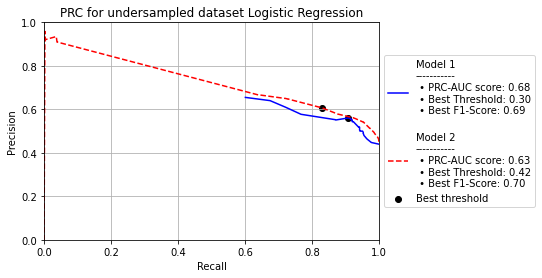

In [24]:
lr_best_threshold1, lr_best_threshold2, lr_us_fig = plot_thresholds(lr1_grid_search, lr2_grid_search, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "undersampled dataset Logistic Regression")

Best Threshold=0.415646, F1-Score=0.701 for model 1
Best Threshold=0.414960, F1-Score=0.701 for model 2


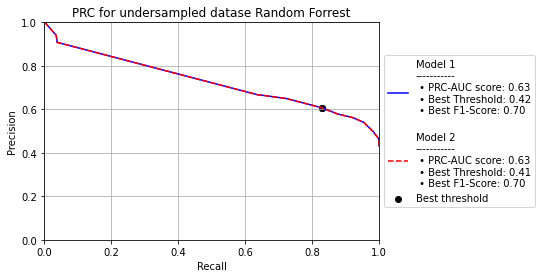

In [25]:
rf_best_threshold1, rf_best_threshold2, rf_us_fig = plot_thresholds(rf1_grid_search, rf2_grid_search, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "undersampled datase Random Forrest")

Best Threshold=0.410680, F1-Score=0.701 for model 1
Best Threshold=0.418522, F1-Score=0.701 for model 2


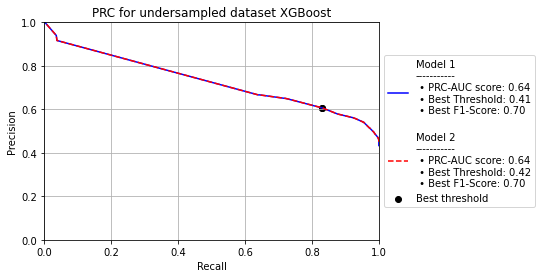

In [26]:
rf_best_threshold1, rf_best_threshold2, xgb_us_fig = plot_thresholds(xgb1_grid_search, xgb2_grid_search, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "undersampled dataset XGBoost")

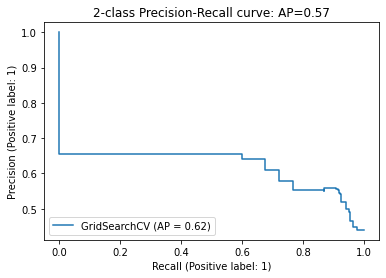

In [27]:
simple_threshold_plot(lr1_grid_search, x1_test, y_test)

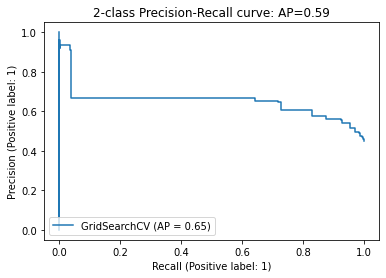

In [28]:
simple_threshold_plot(lr2_grid_search, x2_test, y_test)

In [29]:
lr_prediction_bestthresh1 = (lr1_grid_search.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr2_grid_search.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr1_grid_search, lr2_grid_search)
results_data[21][0] = "Undersampled_Logistic_Regression_Best_Threshold"
results_data[21][1] = lr1_grid_search.score(x1_test, y_test)
results_data[21][2] = lr2_grid_search.score(x2_test, y_test)
results_data[21][3] = acc1
results_data[21][4] = acc2
results_data[21][5] = prc_val1
results_data[21][6] = prc_val2
results_data[21][7] = pr_auc1
results_data[21][8] = pr_auc2

rf_prediction_bestthresh1 = (rf1_grid_search.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf2_grid_search.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf1_grid_search, rf2_grid_search)
results_data[22][0] = "Undersampled_Random_Forrest_Best_Threshold"
results_data[22][1] = rf1_grid_search.score(x1_test, y_test)
results_data[22][2] = rf2_grid_search.score(x2_test, y_test)
results_data[22][3] = acc1
results_data[22][4] = acc2
results_data[22][5] = prc_val1
results_data[22][6] = prc_val2
results_data[22][7] = pr_auc1
results_data[22][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb1_grid_search.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb2_grid_search.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb1_grid_search, xgb2_grid_search)
results_data[23][0] = "Undersampled_XGB_Classifier_Best_Threshold"
results_data[23][1] = xgb1_grid_search.score(x1_test, y_test)
results_data[23][2] = xgb2_grid_search.score(x2_test, y_test)
results_data[23][3] = acc1
results_data[23][4] = acc2
results_data[23][5] = prc_val1
results_data[23][6] = prc_val2
results_data[23][7] = pr_auc1
results_data[23][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.7342031599955938
Average Precision-Recall Score: 0.6184853082119157
PRC-AUC for model 1: 0.6811397420509375
Accuracy: 0.652
Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.46      0.60     12366
           1       0.56      0.91      0.69      9432

    accuracy                           0.65     21798
   macro avg       0.71      0.68      0.65     21798
weighted avg       0.73      0.65      0.64     21798


Scores for model 2
------------------
Roc_Auc Score: 0.7684588328870222
Average Precision-Recall Score: 0.6486887536863128
PRC-AUC for model 2: 0.6309680405944492
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.59      0.69     12366
           1       0.61      0.83      0.70      9432

    accuracy                           0.69     21798
   macro avg       0.71      0.71      0.69     21798
weighted 

#### Oversampling

In [30]:
# For oversampling we will use SMOTE (Synthetic Minority Over-sampling Technique)

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

print("x1_train Before SMOTE:")

print(x1_train.shape)

print("x2_train Before SMOTE:")

print(x2_train.shape)

# Fit the model to generate the data for Model 1.
oversampled_X1, oversampled_Y1 = sm.fit_resample(x1_train, y_train)

# Fit the model to generate the data for Model 2.
oversampled_X2, oversampled_Y2 = sm.fit_resample(x2_train, y_train)

print("x1_train After SMOTE:")

print(oversampled_X1.shape)

print("x2_train After SMOTE:")

print(oversampled_X2.shape)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y2.value_counts(normalize=True) * 100)

osx1 = oversampled_X1
osx2 = oversampled_X2
osy1 = oversampled_Y1
osy2 = oversampled_Y2

x1_train Before SMOTE:
(50859, 5)
x2_train Before SMOTE:
(50859, 129)
x1_train After SMOTE:
(57634, 5)
x2_train After SMOTE:
(57634, 129)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [31]:
'''
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)
'''

lr1_grid_search.fit(oversampled_X1, oversampled_Y1)
print("Logistic regression grid search 1 complete.")
lr2_grid_search.fit(oversampled_X2, oversampled_Y2)
print("Logistic regression grid search 2 complete.")
rf1_grid_search.fit(oversampled_X1, oversampled_Y1)
print("Random Forrest grid search 1 complete.")
rf2_grid_search.fit(oversampled_X2, oversampled_Y2)
print("Random Forrest grid search 2 complete.")
xgb1_grid_search.fit(oversampled_X1, oversampled_Y1)
print("XGB grid search 1 complete.")
xgb2_grid_search.fit(oversampled_X2, oversampled_Y2)
print("XGB grid search 2 complete.")

lr_predictions1 = lr1_grid_search.predict(x1_test)
lr_predictions2 = lr2_grid_search.predict(x2_test)
lr_prediction_probs1 = lr1_grid_search.predict_proba(x1_test)
lr_prediction_probs2 = lr2_grid_search.predict_proba(x2_test)

rf_predictions1 = rf1_grid_search.predict(x1_test)
rf_predictions2 = rf2_grid_search.predict(x2_test)
rf_prediction_probs1 = rf1_grid_search.predict_proba(x1_test)
rf_prediction_probs2 = rf2_grid_search.predict_proba(x2_test)

xgb_predictions1 = xgb1_grid_search.predict(x1_test)
xgb_predictions2 = xgb2_grid_search.predict(x2_test)
xgb_prediction_probs1 = xgb1_grid_search.predict_proba(x1_test)
xgb_prediction_probs2 = xgb2_grid_search.predict_proba(x2_test)

Logistic regression grid search 1 complete.
Logistic regression grid search 2 complete.
Random Forrest grid search 1 complete.
Random Forrest grid search 2 complete.
XGB grid search 1 complete.
XGB grid search 2 complete.


In [32]:
# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr1_grid_search.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr2_grid_search.score(x2_test, y_test)}")
print(f"Logistic regression training best score for model 1: {lr1_grid_search.best_score_}")
print(f"Logistic regression training best score for model 2: {lr2_grid_search.best_score_}")
results_data[36][0] = "Oversampled_Logistic_Regression"
results_data[36][1] = lr1_grid_search.score(x1_test, y_test)
results_data[36][2] = lr2_grid_search.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf1_grid_search.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf2_grid_search.score(x2_test, y_test)}")
print(f"Random Forrest Classification training best score for model 1: {rf1_grid_search.best_score_}")
print(f"Random Forrest Classification training best score for model 2: {rf2_grid_search.best_score_}")
results_data[37][0] = "Oversampled_Random_Forrest"
results_data[37][1] = rf1_grid_search.score(x1_test, y_test)
results_data[37][2] = rf2_grid_search.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb1_grid_search.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb2_grid_search.score(x2_test, y_test)}")
print(f"XGB Classifier training best score for model 1: {xgb1_grid_search.best_score_}")
print(f"XGB Classifier training best score for model 2: {xgb2_grid_search.best_score_}")
results_data[38][0] = "Oversampled_XGB_Classifier"
results_data[38][1] = xgb1_grid_search.score(x1_test, y_test)
results_data[38][2] = xgb2_grid_search.score(x2_test, y_test)

Logistic regression training score for model 1: 0.6903844389393522
Logistic regression training score for model 2: 0.7109367831911184
Logistic regression training best score for model 1: 0.6842488990584965
Logistic regression training best score for model 2: 0.7157235706304654
Random Forrest Classification training score for model 1: 0.711120286264795
Random Forrest Classification training score for model 2: 0.711120286264795
Random Forrest Classification training best score for model 1: 0.7159491265139564
Random Forrest Classification training best score for model 2: 0.7159491235035342
XGB Classifier training score for model 1: 0.711120286264795
XGB Classifier training score for model 2: 0.711120286264795
XGB Classifier training best score for model 1: 0.7158623781877813
XGB Classifier training best score for model 2: 0.7158450291246307


In [33]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr1_grid_search, lr2_grid_search)
results_data[36][3] = acc1
results_data[36][4] = acc2
results_data[36][5] = prc_val1
results_data[36][6] = prc_val2
results_data[36][7] = pr_auc1
results_data[36][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf1_grid_search, rf2_grid_search)
results_data[37][3] = acc1
results_data[37][4] = acc2
results_data[37][5] = prc_val1
results_data[37][6] = prc_val2
results_data[37][7] = pr_auc1
results_data[37][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb1_grid_search, xgb2_grid_search)
results_data[38][3] = acc1
results_data[38][4] = acc2
results_data[38][5] = prc_val1
results_data[38][6] = prc_val2
results_data[38][7] = pr_auc1
results_data[38][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.7370872967713464
Average Precision-Recall Score: 0.6199351513027873
PRC-AUC for model 1: 0.7274907177177863
Accuracy: 0.690
Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.76      0.74     12366
           1       0.65      0.60      0.63      9432

    accuracy                           0.69     21798
   macro avg       0.68      0.68      0.68     21798
weighted avg       0.69      0.69      0.69     21798


Scores for model 2
------------------
Roc_Auc Score: 0.7685684387353378
Average Precision-Recall Score: 0.6497273729278302
PRC-AUC for model 2: 0.7170332556592677
Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.70      0.73     12366
           1       0.65      0.73      0.69      9432

    accuracy      

In [34]:
y_test.value_counts()

0    12366
1     9432
Name: Bug, dtype: int64

###### Compare Precision-Recall thresholds between models for oversampling

Best Threshold=0.357196, F1-Score=0.693 for model 1
Best Threshold=0.487812, F1-Score=0.701 for model 2


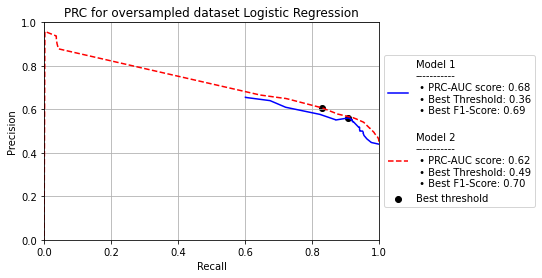

In [35]:
    lr_best_threshold1, lr_best_threshold2, lr_os_fig = plot_thresholds(lr1_grid_search, lr2_grid_search, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "oversampled dataset Logistic Regression")

Best Threshold=0.487352, F1-Score=0.701 for model 1
Best Threshold=0.487659, F1-Score=0.701 for model 2


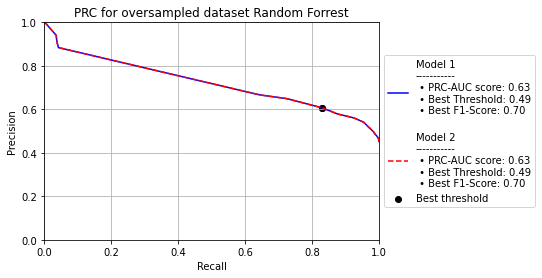

In [36]:
rf_best_threshold1, rf_best_threshold2, rf_os_fig = plot_thresholds(rf1_grid_search, rf2_grid_search, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "oversampled dataset Random Forrest")

Best Threshold=0.488008, F1-Score=0.701 for model 1
Best Threshold=0.488156, F1-Score=0.701 for model 2


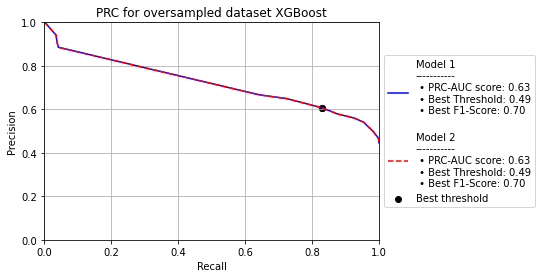

In [37]:
xgb_best_threshold1, xgb_best_threshold2, xgb_os_fig = plot_thresholds(xgb1_grid_search, xgb2_grid_search, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "oversampled dataset XGBoost")

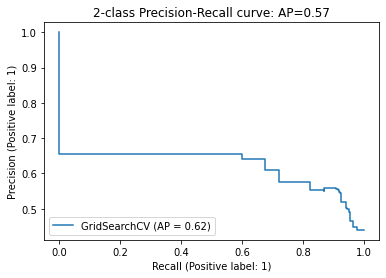

In [38]:
simple_threshold_plot(lr1_grid_search, x1_test, y_test)

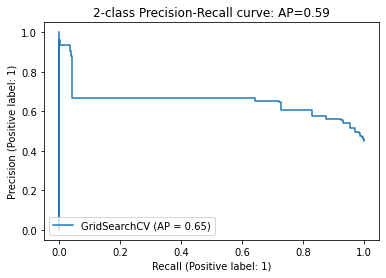

In [39]:
simple_threshold_plot(lr2_grid_search, x2_test, y_test)

Using best threshold...

In [40]:
lr_prediction_bestthresh1 = (lr1_grid_search.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr2_grid_search.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr1_grid_search, lr2_grid_search)
results_data[39][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[39][1] = lr1_grid_search.score(x1_test, y_test)
results_data[39][2] = lr2_grid_search.score(x2_test, y_test)
results_data[39][3] = acc1
results_data[39][4] = acc2
results_data[39][5] = prc_val1
results_data[39][6] = prc_val2
results_data[39][7] = pr_auc1
results_data[39][8] = pr_auc2

rf_prediction_bestthresh1 = (rf1_grid_search.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf2_grid_search.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf1_grid_search, rf2_grid_search)
results_data[40][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[40][1] = rf1_grid_search.score(x1_test, y_test)
results_data[40][2] = rf2_grid_search.score(x2_test, y_test)
results_data[40][3] = acc1
results_data[40][4] = acc2
results_data[40][5] = prc_val1
results_data[40][6] = prc_val2
results_data[40][7] = pr_auc1
results_data[40][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb1_grid_search.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb2_grid_search.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb1_grid_search, xgb2_grid_search)
results_data[41][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[41][1] = xgb1_grid_search.score(x1_test, y_test)
results_data[41][2] = xgb2_grid_search.score(x2_test, y_test)
results_data[41][3] = acc1
results_data[41][4] = acc2
results_data[41][5] = prc_val1
results_data[41][6] = prc_val2
results_data[41][7] = pr_auc1
results_data[41][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.7370872967713464
Average Precision-Recall Score: 0.6199351513027873
PRC-AUC for model 1: 0.6827668876349589
Accuracy: 0.652
Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.46      0.60     12366
           1       0.56      0.91      0.69      9432

    accuracy                           0.65     21798
   macro avg       0.71      0.68      0.65     21798
weighted avg       0.73      0.65      0.64     21798


Scores for model 2
------------------
Roc_Auc Score: 0.7685684387353378
Average Precision-Recall Score: 0.6497273729278302
PRC-AUC for model 2: 0.6231672132144578
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.59      0.69     12366
           1       0.61      0.83      0.70      9432

    accuracy                           0.69     21798
   macro avg       0.71      0.71      0.69     21798
weighted 

##### Combining Oversampling with Undersampling

In [41]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
print("x1 Before SMOTE:")
print(x1_train.shape)
print("x2 Before SMOTE:")
print(x2_train.shape)

# Fit the model to generate the data for Model 1.
oversampled_X1, oversampled_Y1 = sm.fit_resample(x1_train, y_train)

# Fit the model to generate the data for Model 2.
oversampled_X2, oversampled_Y2 = sm.fit_resample(x2_train, y_train)

print("x1 After SMOTE:")
print(oversampled_X1.shape)
print("x2 After SMOTE:")
print(oversampled_X2.shape)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y2.value_counts(normalize=True) * 100)

osx1 = oversampled_X1
osx2 = oversampled_X2
osy1 = oversampled_Y1
osy2 = oversampled_Y2

x1 Before SMOTE:
(50859, 5)
x2 Before SMOTE:
(50859, 129)
x1 After SMOTE:
(57634, 5)
x2 After SMOTE:
(57634, 129)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [42]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

print("x1 Before RandomUnderSampler:")
print(osx1.shape)
print("x2 Before RandomUnderSampler:")
print(osx2.shape)

balanced_x1, balanced_y1, = rus.fit_resample(osx1, osy1)
balanced_x2, balanced_y2, = rus.fit_resample(osx2, osy2)

print("x1 After RandomUnderSampler:")
print(balanced_x1.shape)
print("x2 After RandomUnderSampler:")
print(balanced_x1.shape)

print('\nBalance of positive and negative classes (%):')
print(balanced_y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(balanced_y2.value_counts(normalize=True) * 100)

x1 Before RandomUnderSampler:
(57634, 5)
x2 Before RandomUnderSampler:
(57634, 129)
x1 After RandomUnderSampler:
(57634, 5)
x2 After RandomUnderSampler:
(57634, 5)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [43]:
'''
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)
'''

lr1_grid_search.fit(balanced_x1, balanced_y1)
print("Logistic regression grid search 1 complete.")
lr2_grid_search.fit(balanced_x2, balanced_y2)
print("Logistic regression grid search 2 complete.")
rf1_grid_search.fit(balanced_x1, balanced_y1)
print("Random Forrest grid search 1 complete.")
rf2_grid_search.fit(balanced_x2, balanced_y2)
print("Random Forrest grid search 2 complete.")
xgb1_grid_search.fit(balanced_x1, balanced_y1)
print("XGB grid search 1 complete.")
xgb2_grid_search.fit(balanced_x2, balanced_y2)
print("XGB grid search 2 complete.")

lr_predictions1 = lr1_grid_search.predict(x1_test)
lr_predictions2 = lr2_grid_search.predict(x2_test)
lr_prediction_probs1 = lr1_grid_search.predict_proba(x1_test)
lr_prediction_probs2 = lr2_grid_search.predict_proba(x2_test)

rf_predictions1 = rf1_grid_search.predict(x1_test)
rf_predictions2 = rf2_grid_search.predict(x2_test)
rf_prediction_probs1 = rf1_grid_search.predict_proba(x1_test)
rf_prediction_probs2 = rf2_grid_search.predict_proba(x2_test)

xgb_predictions1 = xgb1_grid_search.predict(x1_test)
xgb_predictions2 = xgb2_grid_search.predict(x2_test)
xgb_prediction_probs1 = xgb1_grid_search.predict_proba(x1_test)
xgb_prediction_probs2 = xgb2_grid_search.predict_proba(x2_test)

Logistic regression grid search 1 complete.
Logistic regression grid search 2 complete.
Random Forrest grid search 1 complete.
Random Forrest grid search 2 complete.
XGB grid search 1 complete.
XGB grid search 2 complete.


In [44]:
# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr1_grid_search.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr2_grid_search.score(x2_test, y_test)}")
print(f"Logistic regression training best score for model 1: {lr1_grid_search.best_score_}")
print(f"Logistic regression training best score for model 2: {lr2_grid_search.best_score_}")
results_data[54][0] = "OSUS_combination_Logistic_Regression"
results_data[54][1] = lr1_grid_search.score(x1_test, y_test)
results_data[54][2] = lr2_grid_search.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf1_grid_search.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf2_grid_search.score(x2_test, y_test)}")
print(f"Random Forrest Classification training best score for model 1: {rf1_grid_search.best_score_}")
print(f"Random Forrest Classification training best score for model 2: {rf2_grid_search.best_score_}")
results_data[55][0] = "OSUS_combination_Random_Forrest"
results_data[55][1] = rf1_grid_search.score(x1_test, y_test)
results_data[55][2] = rf2_grid_search.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb1_grid_search.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb2_grid_search.score(x2_test, y_test)}")
print(f"XGB Classifier training best score for model 1: {xgb1_grid_search.best_score_}")
print(f"XGB Classifier training best score for model 2: {xgb2_grid_search.best_score_}")
results_data[56][0] = "OSUS_combination_XGB_Classifier"
results_data[56][1] = xgb1_grid_search.score(x1_test, y_test)
results_data[56][2] = xgb2_grid_search.score(x2_test, y_test)

Logistic regression training score for model 1: 0.6903844389393522
Logistic regression training score for model 2: 0.7109367831911184
Logistic regression training best score for model 1: 0.6842489863607403
Logistic regression training best score for model 2: 0.7157061493171821
Random Forrest Classification training score for model 1: 0.711120286264795
Random Forrest Classification training score for model 2: 0.711120286264795
Random Forrest Classification training best score for model 1: 0.7159317112215173
Random Forrest Classification training best score for model 2: 0.7159317112215173
XGB Classifier training score for model 1: 0.711120286264795
XGB Classifier training score for model 2: 0.711120286264795
XGB Classifier training best score for model 1: 0.7158623059376484
XGB Classifier training best score for model 2: 0.7158276017905028


In [45]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr1_grid_search, lr2_grid_search)
results_data[54][3] = acc1
results_data[54][4] = acc2
results_data[54][5] = prc_val1
results_data[54][6] = prc_val2
results_data[54][7] = pr_auc1
results_data[54][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf1_grid_search, rf2_grid_search)
results_data[55][3] = acc1
results_data[55][4] = acc2
results_data[55][5] = prc_val1
results_data[55][6] = prc_val2
results_data[55][7] = pr_auc1
results_data[55][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb1_grid_search, xgb2_grid_search)
results_data[56][3] = acc1
results_data[56][4] = acc2
results_data[56][5] = prc_val1
results_data[56][6] = prc_val2
results_data[56][7] = pr_auc1
results_data[56][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.7370395328335363
Average Precision-Recall Score: 0.6198413116368595
PRC-AUC for model 1: 0.7274449180041278
Accuracy: 0.690
Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.76      0.74     12366
           1       0.65      0.60      0.63      9432

    accuracy                           0.69     21798
   macro avg       0.68      0.68      0.68     21798
weighted avg       0.69      0.69      0.69     21798


Scores for model 2
------------------
Roc_Auc Score: 0.7685323349941569
Average Precision-Recall Score: 0.6495929020732794
PRC-AUC for model 2: 0.7168889648724515
Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.70      0.73     12366
           1       0.65      0.73      0.69      9432

    accuracy      

###### Compare Precision-Recall thresholds between models for oversampling and undersampling combination

Best Threshold=0.357037, F1-Score=0.693 for model 1
Best Threshold=0.482348, F1-Score=0.701 for model 2


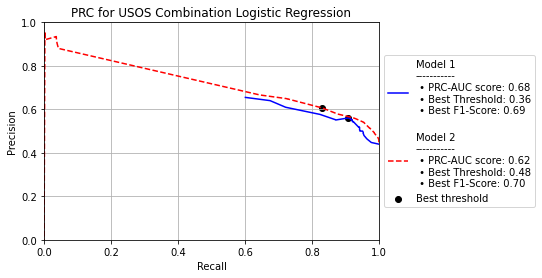

In [46]:
lr_best_threshold1, lr_best_threshold2, lr_osus_fig = plot_thresholds(lr1_grid_search, lr2_grid_search, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "USOS Combination Logistic Regression")

Best Threshold=0.488358, F1-Score=0.701 for model 1
Best Threshold=0.488005, F1-Score=0.701 for model 2


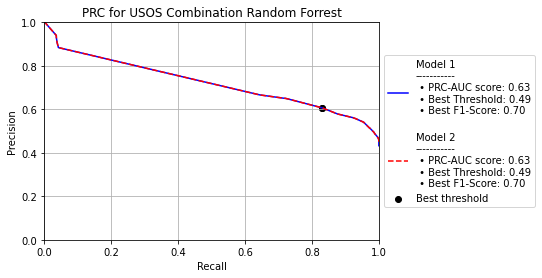

In [47]:
rf_best_threshold1, rf_best_threshold2, rf_osus_fig = plot_thresholds(rf1_grid_search, rf2_grid_search, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "USOS Combination Random Forrest")

Best Threshold=0.488060, F1-Score=0.701 for model 1
Best Threshold=0.488156, F1-Score=0.701 for model 2


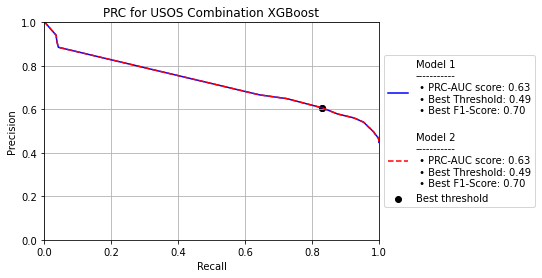

In [48]:
xgb_best_threshold1, xgb_best_threshold2, xgb_osus_fig = plot_thresholds(xgb1_grid_search, xgb2_grid_search, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "USOS Combination XGBoost")

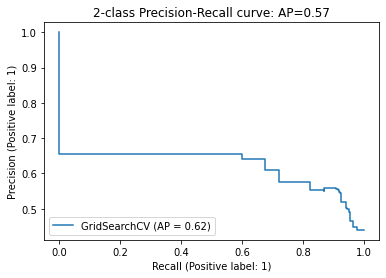

In [49]:
simple_threshold_plot(lr1_grid_search, x1_test, y_test)

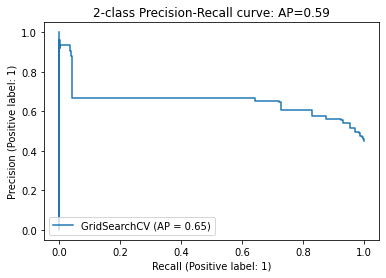

In [50]:
simple_threshold_plot(lr2_grid_search, x2_test, y_test)

Using the best threshold...

In [51]:
lr_prediction_bestthresh1 = (lr1_grid_search.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr2_grid_search.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr1_grid_search, lr2_grid_search)
results_data[57][0] = "OSUS_Logistic_Regression_Best_Threshold"
results_data[57][1] = lr1_grid_search.score(x1_test, y_test)
results_data[57][2] = lr2_grid_search.score(x2_test, y_test)
results_data[57][3] = acc1
results_data[57][4] = acc2
results_data[57][5] = prc_val1
results_data[57][6] = prc_val2
results_data[57][7] = pr_auc1
results_data[57][8] = pr_auc2

rf_prediction_bestthresh1 = (rf1_grid_search.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf2_grid_search.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf1_grid_search, rf2_grid_search)
results_data[58][0] = "OSUS_Random_Forrest_Best_Threshold"
results_data[58][1] = rf1_grid_search.score(x1_test, y_test)
results_data[58][2] = rf2_grid_search.score(x2_test, y_test)
results_data[58][3] = acc1
results_data[58][4] = acc2
results_data[58][5] = prc_val1
results_data[58][6] = prc_val2
results_data[58][7] = pr_auc1
results_data[58][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb1_grid_search.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb2_grid_search.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb1_grid_search, xgb2_grid_search)
results_data[59][0] = "OSUS_XGBoost_Classifier_Best_Threshold"
results_data[59][1] = xgb1_grid_search.score(x1_test, y_test)
results_data[59][2] = xgb2_grid_search.score(x2_test, y_test)
results_data[59][3] = acc1
results_data[59][4] = acc2
results_data[59][5] = prc_val1
results_data[59][6] = prc_val2
results_data[59][7] = pr_auc1
results_data[59][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.7370395328335363
Average Precision-Recall Score: 0.6198413116368595
PRC-AUC for model 1: 0.6827192130335477
Accuracy: 0.652
Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.46      0.60     12366
           1       0.56      0.91      0.69      9432

    accuracy                           0.65     21798
   macro avg       0.71      0.68      0.65     21798
weighted avg       0.73      0.65      0.64     21798


Scores for model 2
------------------
Roc_Auc Score: 0.7685323349941569
Average Precision-Recall Score: 0.6495929020732794
PRC-AUC for model 2: 0.6230310934860142
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.59      0.69     12366
           1       0.61      0.83      0.70      9432

    accuracy                           0.69     21798
   macro avg       0.71      0.71      0.69     21798
weighted 

In [52]:
results_df = pd.DataFrame(results_data, columns = ['Test', 'Model1 score', 'Model2 score', 'Model1 accuracy', 'Model2 accuracy', 'Model1 avg. PR score', 'Model2 avg. PR score', 'Model1 PRC-AUC Score', 'Model2 PRC-AUC Score'])
model1_results_df = results_df[['Test', 'Model1 score', 'Model1 accuracy', 'Model1 avg. PR score', 'Model1 PRC-AUC Score']]
model2_results_df = results_df[['Test', 'Model2 score', 'Model2 accuracy', 'Model2 avg. PR score', 'Model2 PRC-AUC Score']]

In [53]:
results_df

,Test,Model1 score,Model2 score,Model1 accuracy,Model2 accuracy,Model1 avg. PR score,Model2 avg. PR score,Model1 PRC-AUC Score,Model2 PRC-AUC Score
0,Original_Logistic_Regression,0.690384,0.711396,0.690384,0.711396,0.618485,0.648689,0.725860,0.724826
1,Original_Random_Forrest,0.711579,0.711212,0.711579,0.711212,0.650120,0.650060,0.723062,0.723011
2,Original_XGB_Classifier,0.711533,0.711579,0.711533,0.711579,0.649036,0.649081,0.729684,0.729721
3,Original_Logistic_Regression_Best_Threshold,0.690384,0.711396,0.651619,0.693550,0.618485,0.648689,0.681140,0.630968
4,Original_Random_Forrest_Best_Threshold,0.711579,0.711212,0.693733,0.693733,0.650120,0.650060,0.629179,0.629149
...,...,...,...,...,...,...,...,...,...
67,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
model1_results_df

,Test,Model1 score,Model1 accuracy,Model1 avg. PR score,Model1 PRC-AUC Score
0,Original_Logistic_Regression,0.690384,0.690384,0.618485,0.725860
1,Original_Random_Forrest,0.711579,0.711579,0.650120,0.723062
2,Original_XGB_Classifier,0.711533,0.711533,0.649036,0.729684
3,Original_Logistic_Regression_Best_Threshold,0.690384,0.651619,0.618485,0.681140
4,Original_Random_Forrest_Best_Threshold,0.711579,0.693733,0.650120,0.629179
...,...,...,...,...,...
67,None,NaN,NaN,NaN,NaN
68,None,NaN,NaN,NaN,NaN
69,None,NaN,NaN,NaN,NaN
70,None,NaN,NaN,NaN,NaN


In [55]:
model2_results_df

,Test,Model2 score,Model2 accuracy,Model2 avg. PR score,Model2 PRC-AUC Score
0,Original_Logistic_Regression,0.711396,0.711396,0.648689,0.724826
1,Original_Random_Forrest,0.711212,0.711212,0.650060,0.723011
2,Original_XGB_Classifier,0.711579,0.711579,0.649081,0.729721
3,Original_Logistic_Regression_Best_Threshold,0.711396,0.693550,0.648689,0.630968
4,Original_Random_Forrest_Best_Threshold,0.711212,0.693733,0.650060,0.629149
...,...,...,...,...,...
67,None,NaN,NaN,NaN,NaN
68,None,NaN,NaN,NaN,NaN
69,None,NaN,NaN,NaN,NaN
70,None,NaN,NaN,NaN,NaN


In [56]:
model1_results_df[~model1_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model1 PRC-AUC Score', 'Model1 score'], ascending=False)

,Test,Model1 score,Model1 accuracy,Model1 avg. PR score,Model1 PRC-AUC Score
2,Original_XGB_Classifier,0.711533,0.711533,0.649036,0.729684
20,Undersampled_XGB_Classifier,0.711533,0.711533,0.649036,0.729684
36,Oversampled_Logistic_Regression,0.690384,0.690384,0.619935,0.727491
54,OSUS_combination_Logistic_Regression,0.690384,0.690384,0.619841,0.727445
19,Undersampled_Random_Forrest,0.711579,0.711579,0.649003,0.727154
...,...,...,...,...,...
67,None,NaN,NaN,NaN,NaN
68,None,NaN,NaN,NaN,NaN
69,None,NaN,NaN,NaN,NaN
70,None,NaN,NaN,NaN,NaN


In [57]:
model2_results_df[~model2_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model2 PRC-AUC Score'], ascending=False)

,Test,Model2 score,Model2 accuracy,Model2 avg. PR score,Model2 PRC-AUC Score
2,Original_XGB_Classifier,0.711579,0.711579,0.649081,0.729721
20,Undersampled_XGB_Classifier,0.711579,0.711579,0.649081,0.729721
19,Undersampled_Random_Forrest,0.711579,0.711579,0.649049,0.727197
0,Original_Logistic_Regression,0.711396,0.711396,0.648689,0.724826
18,Undersampled_Logistic_Regression,0.711396,0.711396,0.648689,0.724826
...,...,...,...,...,...
67,None,NaN,NaN,NaN,NaN
68,None,NaN,NaN,NaN,NaN
69,None,NaN,NaN,NaN,NaN
70,None,NaN,NaN,NaN,NaN


In [58]:
'''
figures = [lr_skf_og_fig, rf_skf_os_fig, xgb_skf_os_fig]

for i, figure in enumerate(figures):
    figure.savefig(f"../../img/ActiveMQ/graphs/Precision vs. Recall Results/Figure_{i}", dpi=300, bbox_inches='tight')
'''

'\nfigures = [lr_skf_og_fig, rf_skf_os_fig, xgb_skf_os_fig]\n\nfor i, figure in enumerate(figures):\n    figure.savefig(f"../../img/ActiveMQ/graphs/Precision vs. Recall Results/Figure_{i}", dpi=300, bbox_inches=\'tight\')\n'

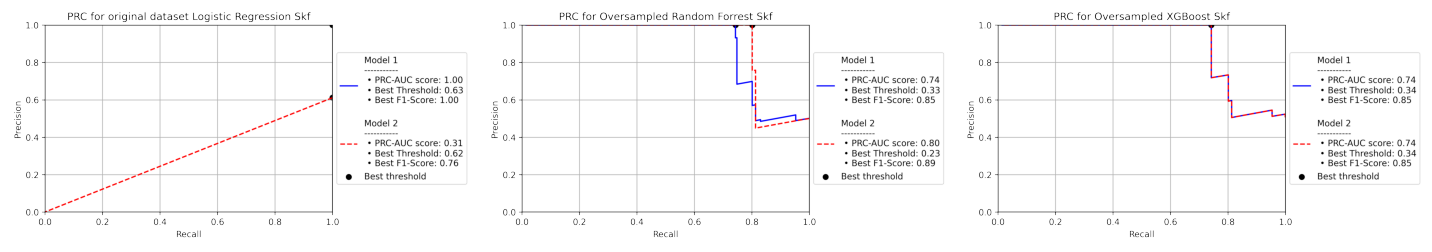

In [59]:
img_A = mpimg.imread('../../img/ActiveMQ/graphs/Precision vs. Recall Results/Figure_0.png')
img_B = mpimg.imread('../../img/ActiveMQ/graphs/Precision vs. Recall Results/Figure_1.png')
img_C = mpimg.imread('../../img/ActiveMQ/graphs/Precision vs. Recall Results/Figure_2.png')
# display images
fig, ax = plt.subplots(1,3,figsize=(20,20))
ax[0].imshow(img_A);
ax[0].axis('off')
ax[1].imshow(img_B);
ax[1].axis('off')
ax[2].imshow(img_C);
ax[2].axis('off')
fig.tight_layout()
fig.savefig(f"../../img/ActiveMQ/graphs/Precision vs. Recall Results/Figure_final.png", dpi=300, bbox_inches='tight')